In [1]:
import sys
sys.path.append('../')

In [2]:
from scripts.utils import data_path
from scripts.cross_match_scripts import build_keras_model, plot_metrics, assess_classifier, save_keras_classifier, assess_classifier, photo_prior_create_train_test_validation_data
import pandas as pd
from tqdm import tqdm
pd.set_option('display.max_columns', 500)
import seaborn as sns
import numpy as np
import pickle
%matplotlib inline
photo_cat_scaled = pd.read_pickle('model/train_test_validation_data.pkl')

load_models = False


matplotlib settings set


matplotlib settings set


## GRZ data 

In [3]:
learning_dict = photo_prior_create_train_test_validation_data(photo_cat_scaled=photo_cat_scaled, features_cols = 'grz')

total x-ray sources:  11092
total non-x-ray sources:  141845
total sources:  152937
number of x-ray sources per flux bin:
x_ray_flux_bin
0    11092
dtype: int64
number of non-x-ray sources per flux bin:
x_ray_flux_bin
0    141845
dtype: int64
x-ray flux bins:
[3.00076359e-15 3.92776796e-12]
********************
flux bin:  3.0007635913564e-15 3.927767961003e-12
train features: 
  ['rel_dered_mag_g', 'rel_dered_mag_r', 'rel_dered_mag_z', 'rel_dered_g_r', 'rel_dered_r_z', 'rel_dered_g_z']
train size examples - filed:  79433
train size examples - x-ray: 6211
test size examples - filed:  19859
test size examples - x-ray 1553
validation size examples - filed:  42553
validation size examples - x-ray: 3328
downsampled field sources:  False
data is scaled


In [4]:
X_train, y_train, X_test, y_test, X_val, y_val = learning_dict[0]['X_train'], learning_dict[0]['y_train'], learning_dict[0]['X_test'], learning_dict[0]['y_test'], learning_dict[0]['X_val'], learning_dict[0]['y_val']


X_all = np.concatenate((X_train, X_test, X_val))
y_all = np.concatenate((y_train, y_test, y_val))[:,0]


#X_ctps = X_all[y_all == 1]
#X_field = X_all[y_all == 0]

features = ['rel_dered_mag_g', 'rel_dered_mag_r', 'rel_dered_mag_z', 'rel_dered_g_r', 'rel_dered_r_z', 'rel_dered_g_z']


df = pd.DataFrame(X_all, columns=features)
df['is_counterpart'] = y_all
df

,rel_dered_mag_g,rel_dered_mag_r,rel_dered_mag_z,rel_dered_g_r,rel_dered_r_z,rel_dered_g_z,is_counterpart
0,0.689982,0.668886,0.639144,0.073838,0.104096,0.177934,False
1,0.679099,0.635154,0.615901,0.153809,0.067387,0.221196,False
2,0.685288,0.652018,0.607449,0.116445,0.155992,0.272437,False
3,0.580318,0.538355,0.517007,0.146869,0.074718,0.221587,False
4,0.595309,0.555716,0.517328,0.138576,0.134360,0.272936,False
...,...,...,...,...,...,...,...
152932,0.507009,0.493842,0.489893,0.046083,0.013820,0.059903,False
152933,0.607580,0.577877,0.564216,0.103961,0.047811,0.151772,False
152934,0.667046,0.651707,0.635102,0.053686,0.058119,0.111805,False
152935,0.678653,0.668486,0.661820,0.035583,0.023331,0.058914,False


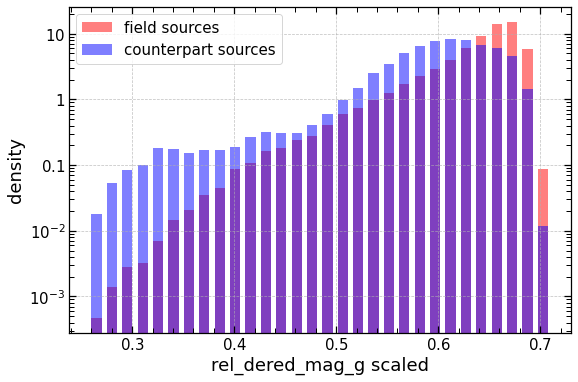

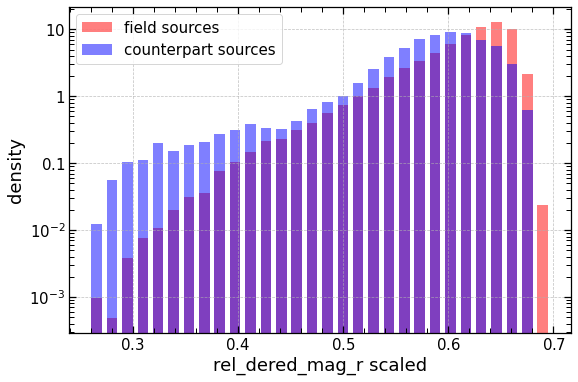

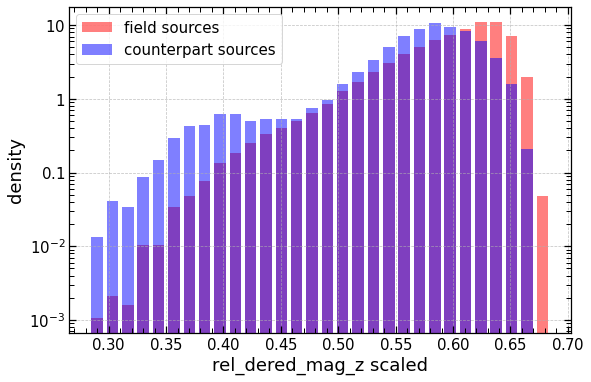

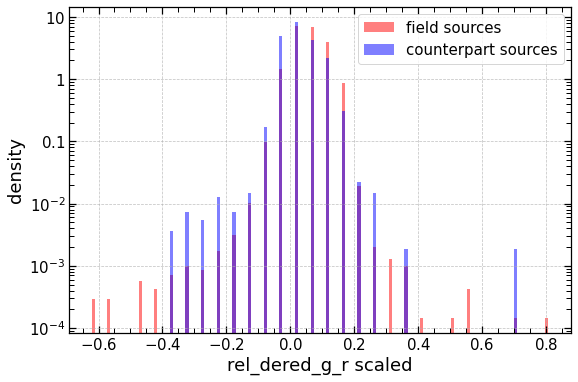

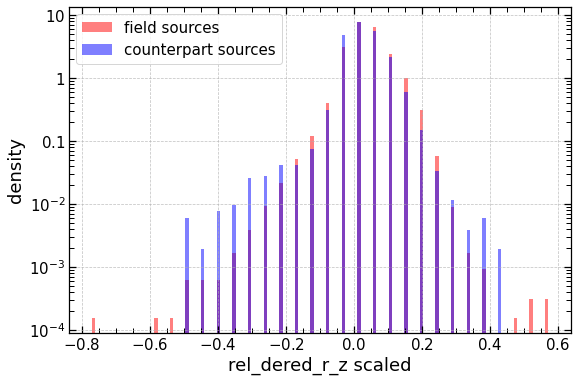

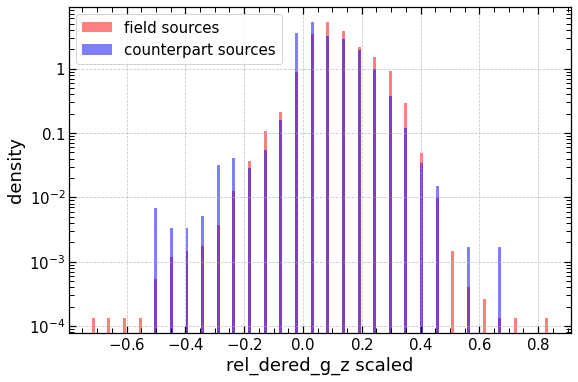

In [5]:
histbins = 30
for feature in features:
    f_ctps = df[df['is_counterpart'] == 1][feature]
    f_field = df[df['is_counterpart'] == 0][feature]

    #bins = np.linspace(f_field.min(), f_field.max(), histbins)
    hist_field, bin_field = np.histogram(f_field, bins=histbins, density=True)  
    hist_ctsp, bin_ctsp = np.histogram(f_ctps, bins=bin_field, density=True)

    plt.figure(figsize=(9,6))
    plt.bar(bin_field[:-1], hist_field, width=0.01, color='r', label='field sources', alpha = 0.5)
    plt.bar(bin_ctsp[:-1], hist_ctsp, width=0.01, color='b', label='counterpart sources', alpha = 0.5)
    plt.legend()
    plt.yscale('log')
    plt.xlabel(feature+' scaled')
    plt.ylabel('density')

    #save histograms in one file:
    #with columns lo, hi, selected, others
    hist_df = pd.DataFrame({'lo':bin_field[:-1], 'hi':bin_field[1:], 'selected':hist_ctsp, 'others':hist_field})

    hist_df.to_csv('./model/'+ feature +'.csv', index=False, sep = '\t', header = ['#lo', 'hi', 'selected', 'others'])




same as above, but without scaling

data unscaled: rel_dered_mag for mags,  rel_dered and not mag_ for colors


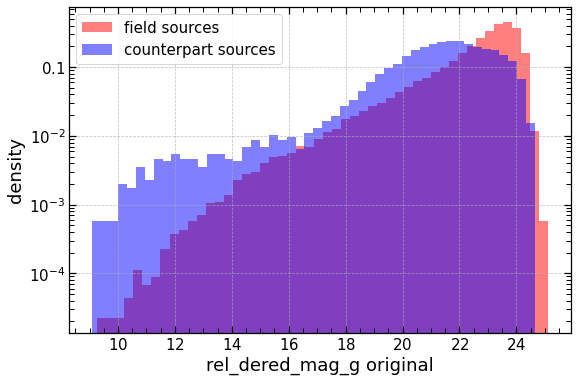

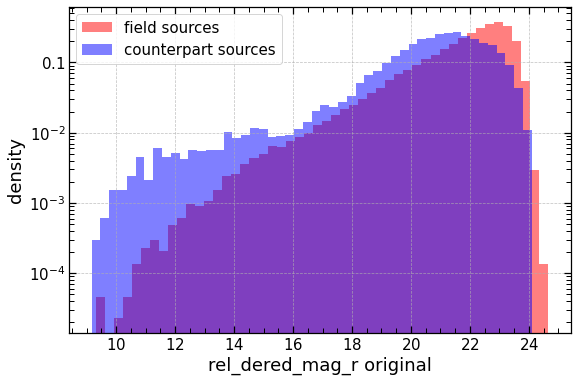

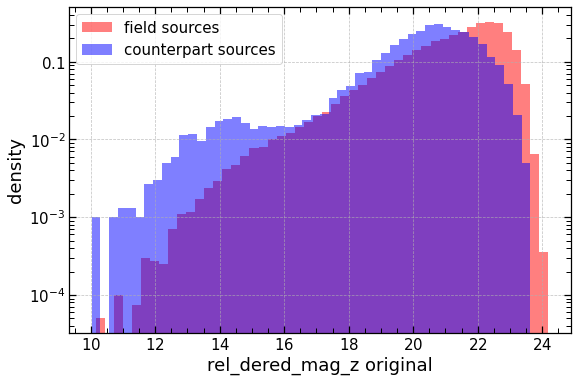

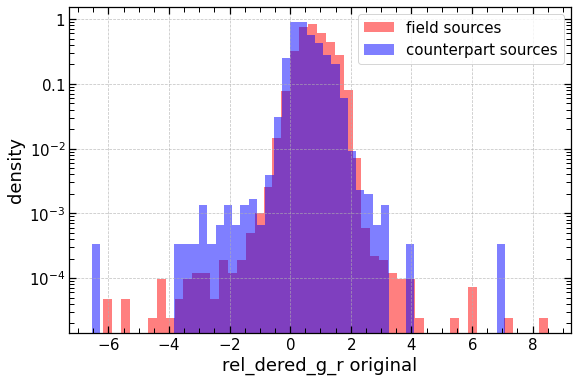

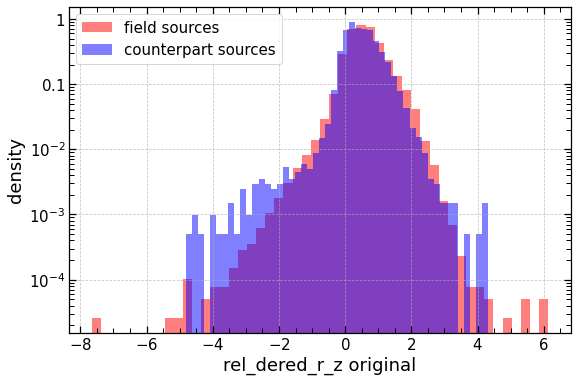

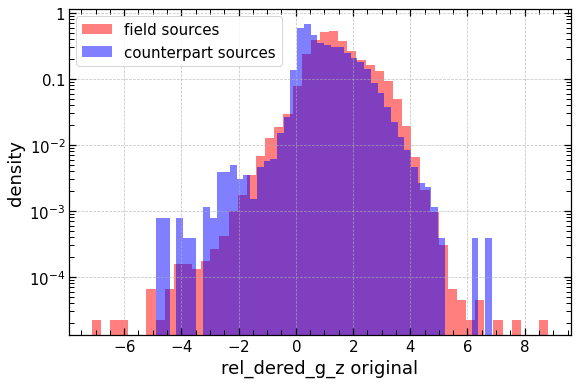

In [6]:
from scripts.cross_match_scripts import my_scaler_backward
df_orig = my_scaler_backward(df)
histbins = 50
for feature in features:
    f_ctps = df_orig[df_orig['is_counterpart'] == 1][feature]
    f_field = df_orig[df_orig['is_counterpart'] == 0][feature]


    bins = np.linspace(f_field.min(), f_field.max(), histbins)
    plt.figure(figsize=(9,6))
    plt.hist(f_field, bins=histbins, color='r', label='field sources', alpha = 0.5, density=True)
    plt.hist(f_ctps, bins=histbins, color='b', label='counterpart sources', alpha = 0.5, density=True)
    plt.legend()
    plt.yscale('log')
    plt.xlabel(feature+' original')
    plt.ylabel('density')




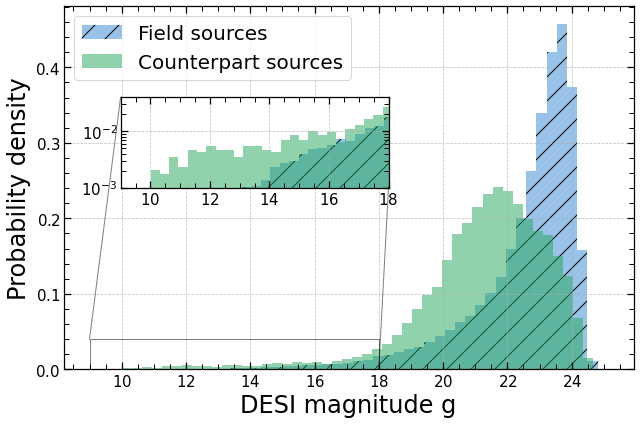

In [8]:
feature = 'rel_dered_mag_g'
f_ctps = df_orig[df_orig['is_counterpart'] == 1][feature]
f_field = df_orig[df_orig['is_counterpart'] == 0][feature]


fig,  ax =  plt.subplots( figsize = (9,6))
bins = np.linspace(f_field.min(), f_field.max(), histbins)

ax.hist(f_field, bins=histbins, color='C0', label='Field sources', alpha = 0.5, density=True, hatch='/')
ax.hist(f_ctps, bins=histbins, color='C2', label='Counterpart sources', alpha = 0.5, density=True)
#plt.yscale('log')
#plt.yscale('symlog', linthresh=0.01)
#plt.yscale('function', lambda x: x)
ax.set_xlabel('DESI magnitude g', fontsize = 24)
ax.set_ylabel('Probability density', fontsize = 24)

axins = ax.inset_axes([0.1, 0.5, 0.47, 0.25])
axins.hist(f_field, bins=histbins, color='C0', label='Field sources', alpha = 0.5, density=True, hatch='/')
axins.hist(f_ctps, bins=histbins, color='C2', label='Counterpart sources', alpha = 0.5, density=True, )

# sub region of the original image
x1, x2, y1, y2 = 9, 18, 1e-3, 0.04
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])
axins.set_yscale('log')
ax.indicate_inset_zoom(axins, edgecolor="black")
ax.legend(fontsize = 20)


fig.tight_layout()

plt.savefig(data_path+'/paper_plots/mag_g_dist.pdf')


